# Low-Rank Structure in Gaussian Covariances

This notebook explores how low-rank changes in Gaussian coefficient matrices affect covariance structure.
The emphasis is on empirical covariance, eigenvalues, and matrix rank.

## Background

$$
x = W z + \varepsilon,\quad z \sim \mathcal{N}(0, I_k),\quad \varepsilon \sim \mathcal{N}(0, \sigma^2 I_d)
$$

$$
\Sigma = W W^\top + \sigma^2 I_d.
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigvalsh

rng = np.random.default_rng(0)

In [2]:
d = 40
k = 8
sigma = 0.1
n = 1500

W0 = rng.normal(size=(d, k))
Sigma0 = W0 @ W0.T + sigma**2 * np.eye(d)

## Low-Rank vs Diffuse Coefficient Changes

In [3]:
rank_star = 2

B = rng.normal(size=(d, rank_star))
A = rng.normal(size=(rank_star, k))
DeltaW_lr = B @ A

D = rng.normal(size=(d, k))
DeltaW_dense = D / np.linalg.norm(D, 'fro') * np.linalg.norm(DeltaW_lr, 'fro')

In [4]:
def sample(W):
    z = rng.normal(size=(n, k))
    eps = sigma * rng.normal(size=(n, d))
    return z @ W.T + eps

S_lr = (sample(W0 + DeltaW_lr).T @ sample(W0 + DeltaW_lr)) / n
S_dense = (sample(W0 + DeltaW_dense).T @ sample(W0 + DeltaW_dense)) / n

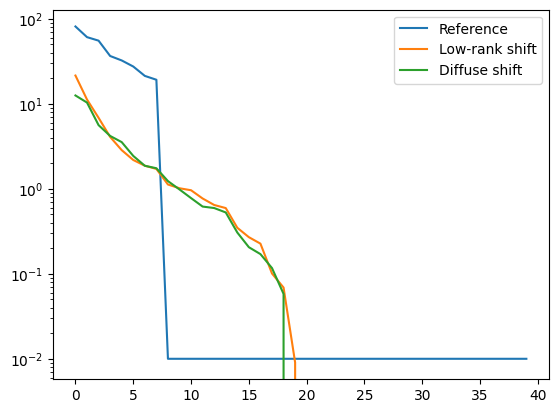

In [5]:
eig0 = eigvalsh(Sigma0)
eig_lr = eigvalsh(S_lr)
eig_dense = eigvalsh(S_dense)

plt.semilogy(eig0[::-1], label='Reference')
plt.semilogy(eig_lr[::-1], label='Low-rank shift')
plt.semilogy(eig_dense[::-1], label='Diffuse shift')
plt.legend()
plt.show()

In [6]:
def get_sorted_eigvalsh(matrix):
  eigvals = eigvalsh(matrix)
  return eigvals[::-1] # Now it's in sorted descending order

eig_0 = get_sorted_eigvalsh(Sigma0)
eig_lowrank = get_sorted_eigvalsh(S_lr)
eig_diffuse = get_sorted_eigvalsh(S_dense)

print(f"Top 5 Ref: {eig_0[:5]}")
print(f"Top 5 Lr: {eig_lowrank[:5]}")
print(f"Top 5 Diff:  {eig_diffuse[:5]}")

Top 5 Ref: [81.29049888 60.89757627 55.35903094 36.54482512 32.38554313]
Top 5 Lr: [21.51568677 11.23013604  6.8473077   4.08190827  2.85214667]
Top 5 Diff:  [12.54075158 10.34373131  5.61342923  4.1888489   3.54381156]


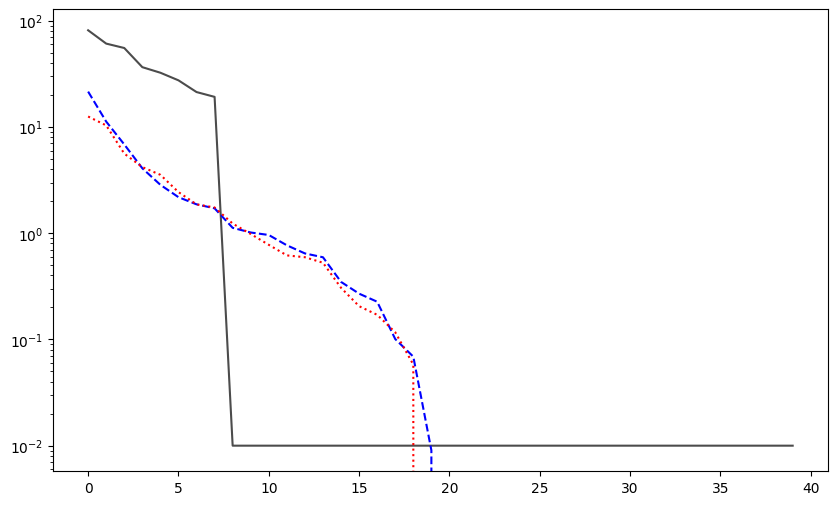

In [7]:
plt.figure(figsize=(10, 6))

plt.plot(eig_0, label=r'Reference $\Sigma_0$', color='black', alpha=0.7)
plt.plot(eig_lowrank, label=r'Low-rank $S_{low-rank}$', linestyle='--', color='blue')
plt.plot(eig_diffuse, label=r'Diffuse $S_{diffuse}$', linestyle=':', color='red')

plt.yscale('log')

In [8]:
def count_significant_changes(e_ref, e_mod, threshold=0.10):
    relative_diff = np.abs(e_mod - e_ref) / e_ref
    count = np.sum(relative_diff > threshold)
    return count

count_lr = count_significant_changes(eig_0, eig_lowrank)
count_diffuse = count_significant_changes(eig_0, eig_diffuse)

print(f"Number of significantly changed eigenvalues (Low-rank): {count_lr}")
print(f"Number of significantly changed eigenvalues (Diffuse):  {count_diffuse}")

Number of significantly changed eigenvalues (Low-rank): 39
Number of significantly changed eigenvalues (Diffuse):  40


1. In the low-rank case, how many eigenvalues change substantially, and how does this number relate to the rank of the coefficient modification?
39 eigenvalues changed substantially (by more than 10%). This number is directly determined by the rank of the coefficient modification. The low-rank modification injects additional variance onto into geometric directions. The remaining data is untouched, so their eigenvalues are unchanged.

2. In the diffuse case, why are many eigenvalues affected, even though the overall magnitude of the change is the same?

I expected more eigenvalues to be changed, but only 40 (1 more than low-rank) was changed. The modification should've affected all available geometric directions of variance, and thus affected the eigenvalues of all the data.

3. How do these observations illustrate the idea that matrix rank limits the number of variance directions that can change?

These observations show that rank acts as a limit on the "degrees of freedom" for change within a covariance structure. A low rank strictly constrains the modification to a narrow subspace, meaning only a limited number of geometric directions of variance can be altered. Conversely, a high-rank or diffuse modification lacks this constraint, allowing it to disturb the entire data space. This demonstrates that the rank defines how many independent directions in the data will actually experience a shift in their eigenvalues.
